In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import keras
from tensorflow.keras import datasets, layers, models

In [2]:
print(os.listdir("data"))

['test', 'train']


# Read Data

In [3]:
trainBenign_folder = "data/train/benign"
trainMalignant_folder = "data/train/malignant"

testBenign_folder = "data/test/benign"
testMalignant_folder = "data/test/malignant"

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training images
ims_benign = [read(os.path.join(trainBenign_folder, filename)) for filename in os.listdir(trainBenign_folder)]
X_benign = np.array(ims_benign, dtype='uint8') # numpy array of shape (n_images, image_width, image_height, n_channels) 
ims_malignant = [read(os.path.join(trainMalignant_folder, filename)) for filename in os.listdir(trainMalignant_folder)]
X_malignant = np.array(ims_malignant, dtype='uint8') # numpy array of shape (n_images, image_width, image_height, n_channels)

# Load in testing images
ims_benign_test = [read(os.path.join(testBenign_folder, filename)) for filename in os.listdir(testBenign_folder)]
X_benign_test = np.array(ims_benign_test, dtype='uint8') # numpy array of shape (n_images, image_width, image_height, n_channels)
ims_malignant_test = [read(os.path.join(testMalignant_folder, filename)) for filename in os.listdir(testMalignant_folder)]
X_malignant_test = np.array(ims_malignant_test, dtype='uint8') # numpy array of shape (n_images, image_width, image_height, n_channels)

# Create labels
y_benign = np.zeros(X_benign.shape[0]) # benign images have label 0
y_malignant = np.ones(X_malignant.shape[0]) # malignant images have label 1

y_benign_test = np.zeros(X_benign_test.shape[0]) # benign images have label 0
y_malignant_test = np.ones(X_malignant_test.shape[0]) # malignant images have label 1

# Merge benign and malignant images
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

In [4]:
print("Training Data: ", len(X_train))
print("Testing Data: ", len(X_test))

Training Data:  2637
Testing Data:  660


In [5]:
# check shape of images
for i in range(0, 10):
    print(X_test[i].shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


# Display dataset

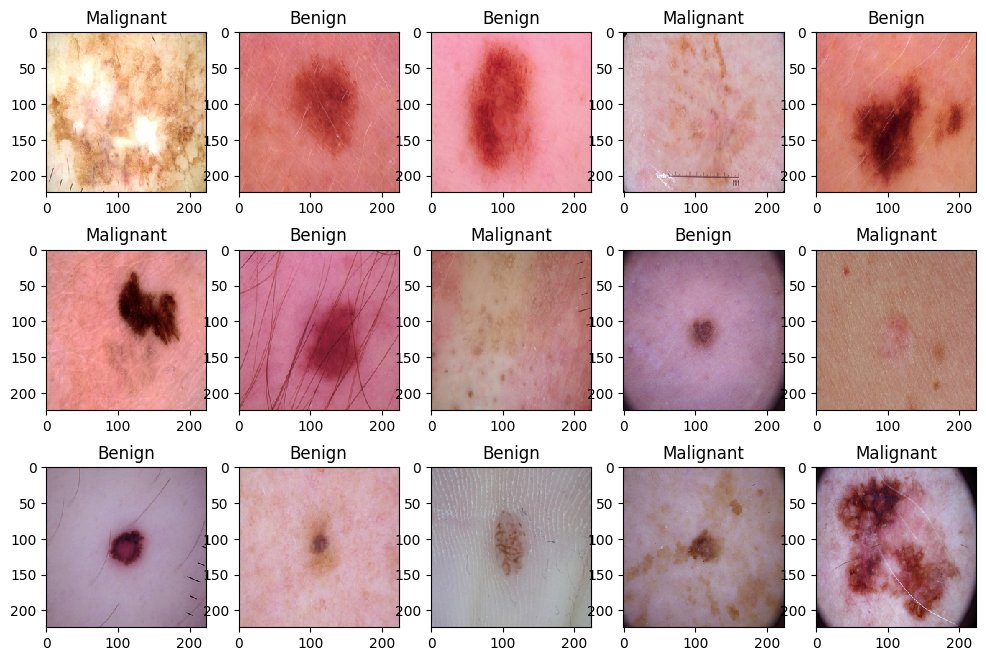

In [53]:
# Display 15 training images of moles and their true labels
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

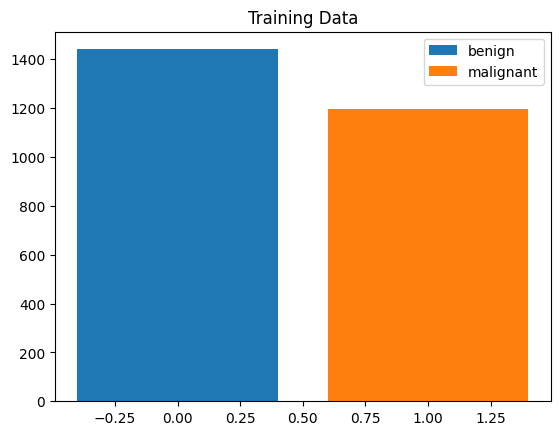

benign:  1440
malignant:  1197


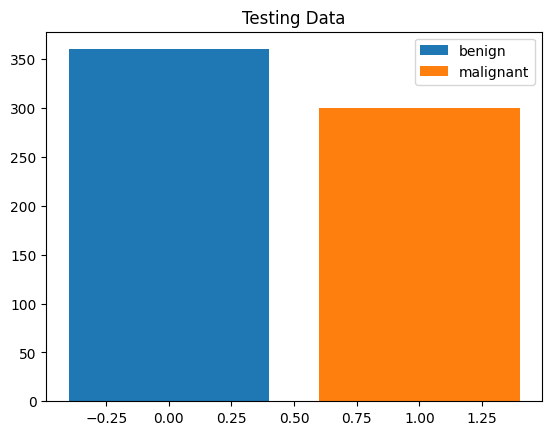

benign:  360
malignant:  300


In [55]:
plt.bar(0, y_train[np.where(y_train == 0)].shape[0], label = 'benign')
plt.bar(1, y_train[np.where(y_train == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Training Data")
plt.show()
print("benign: ", len(y_train[np.where(y_train == 0)]))
print("malignant: ", len(y_train[np.where(y_train == 1)]))

plt.bar(0, y_test[np.where(y_test == 0)].shape[0], label = 'benign')
plt.bar(1, y_test[np.where(y_test == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Testing Data")
plt.show()
print("benign: ", len(y_test[np.where(y_test == 0)]))
print("malignant: ", len(y_test[np.where(y_test == 1)]))

# Scale values

Normalize pixel values so that they range between 0-1 by dividing them by 255 

In [8]:
X_train = X_train/255.
X_test = X_test/255.

# Data Augmentation
Augment the data in order to increase the amount and variety of our training data since it is relatively limited, as well as to avoid overfitting

In [9]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True 
)

datagen.fit(X_train)

# Picking a pre-trained Model

MobileNetV2 is a pretrained CNN model, released by Google and built into Tensorflow, that is trained on millions of images. It can be very helpful in achieving high accuracy in  image classification problems.

In [10]:
IMG_shape = X_train[0].shape

# create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_shape,
                                               include_top=False, #removes the last layer (classification layer)
                                               weights='imagenet')

In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

# Freeze the base
freezing implies turning off the ability of a layer to be trained. Essentially, we're ensuring that the weights of the frozen layers remain unchanged during the training process. This step is crucial because we aim to preserve the already learned weights in the convolutional base.

In [12]:
base_model.trainable = False

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

# Adding our classifier 
To generate predictions from the block of features, average over the spatial 7x7 spatial locations, using a GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.
  
  Apply a Dense layer with 1 dense neuron to convert these features into a single prediction per image. An activation function is not needed here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(1)

In [15]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
    ])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


# Training the model

In [17]:
base_learning_rate = 0.00166
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# We can evaluate the model right now to see how it does before training it on our new images
steps = 20

loss0,accuracy0 = model.evaluate(X_test, y_test, steps = steps)

20/20 [==============================] - 12s 490ms/step - loss: 0.9970 - accuracy: 0.5455


In [19]:
# early stoppage callback function 
early_stopping_calback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [20]:
len(X_train)

2637

In [21]:
# Train model on our images
history = model.fit(datagen.flow(X_train, y_train), epochs = 10, callbacks=[early_stopping_calback])

acc = history.history['accuracy']
print(acc)

Epoch 1/10
83/83 [==============================] - 60s 658ms/step - loss: 0.5152 - accuracy: 0.7421
Epoch 2/10
83/83 [==============================] - 52s 623ms/step - loss: 0.4313 - accuracy: 0.7880
Epoch 3/10
83/83 [==============================] - 53s 634ms/step - loss: 0.3995 - accuracy: 0.8055
Epoch 4/10
83/83 [==============================] - 52s 623ms/step - loss: 0.4019 - accuracy: 0.8039
Epoch 5/10
83/83 [==============================] - 52s 629ms/step - loss: 0.3886 - accuracy: 0.8203
Epoch 6/10
83/83 [==============================] - 54s 654ms/step - loss: 0.3778 - accuracy: 0.8157
Epoch 7/10
83/83 [==============================] - 50s 601ms/step - loss: 0.3681 - accuracy: 0.8199
Epoch 8/10
83/83 [==============================] - 55s 663ms/step - loss: 0.3578 - accuracy: 0.8225
Epoch 9/10
83/83 [==============================] - 52s 621ms/step - loss: 0.3478 - accuracy: 0.8343
Epoch 10/10
83/83 [==============================] - 50s 599ms/step - loss: 0.3547 - accura

In [22]:
model.save('Skin_Cancer_Classifier_Model.h5')

# Evaluate the model

In [23]:
loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy: ", test_accuracy)

21/21 [==============================] - 12s 515ms/step - loss: 0.3752 - accuracy: 0.8227
Test accuracy:  0.8227272629737854


In [28]:
# Plot Model Histories
def plot_history(histories, key='accuracy'):
    loss = np.array(history.history['loss'])
    accuracy = np.array(history.history['accuracy'])
    epochs = range(len(history.history['loss']))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.set_title('Loss', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()
    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.set_title('Accuracy', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend()
    sns.despine();

In [42]:
# generate model probabilities and predictions
test_probabilities = model.predict(X_test, verbose=1)
# If the model outputs probabilities for the positive class
test_predictions = (test_probabilities > 0.5).astype(int)

21/21 [==============================] - 12s 558ms/step


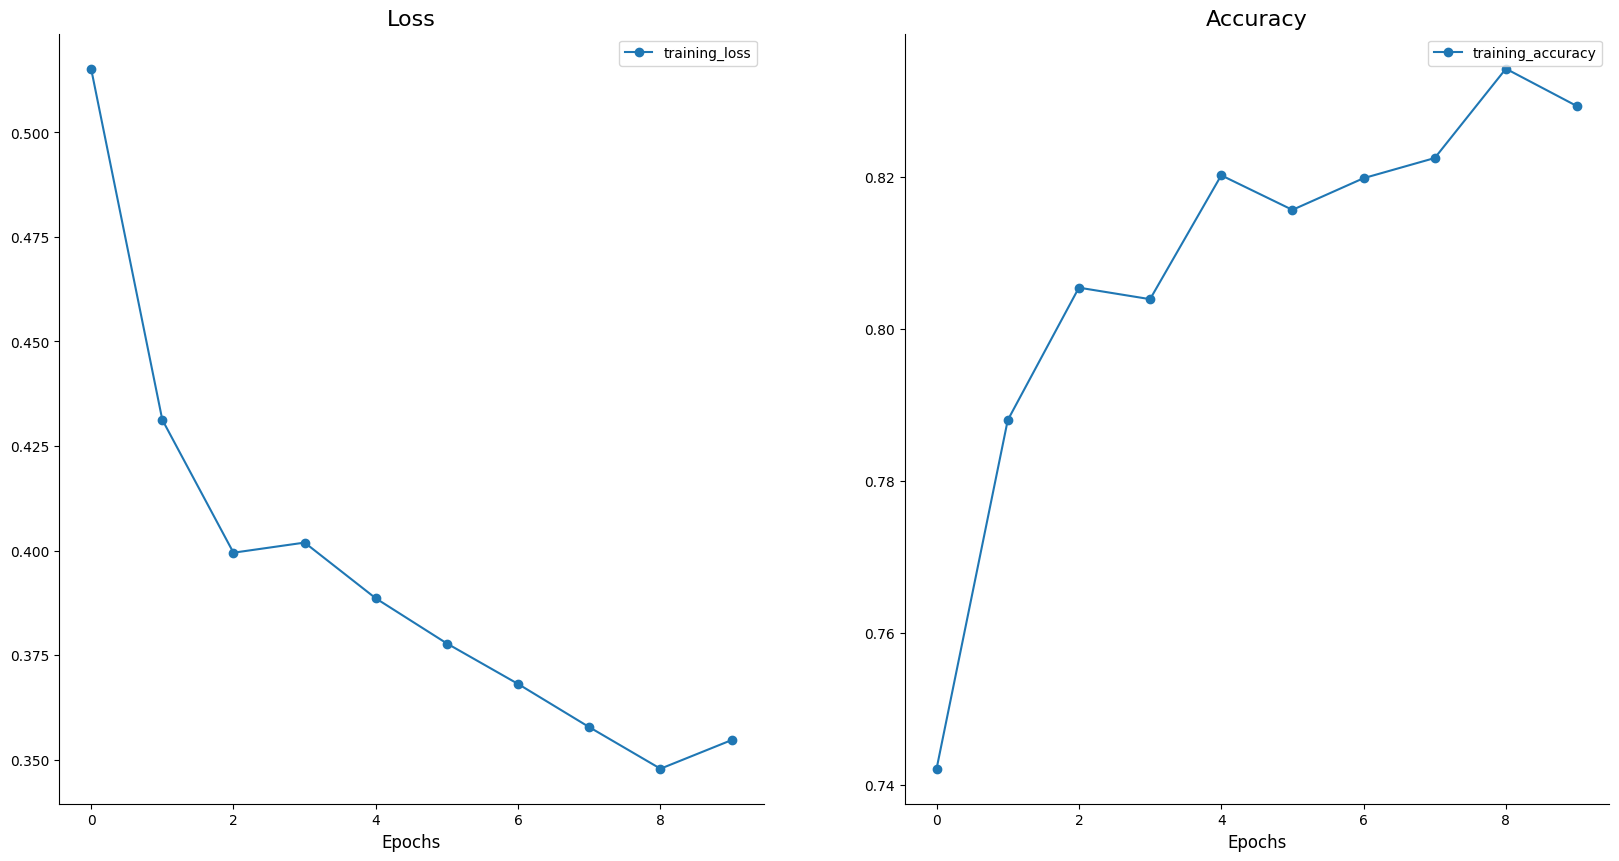

In [29]:
plot_history(history)

# Predicting

In [46]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10,10), text_size=12):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    plt.show()

    #show which is the True Positives, true negatives, false positives and false negatives
    TN, FP, FN, TP = cm.ravel()
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    print('True Positives:', TP)
    return


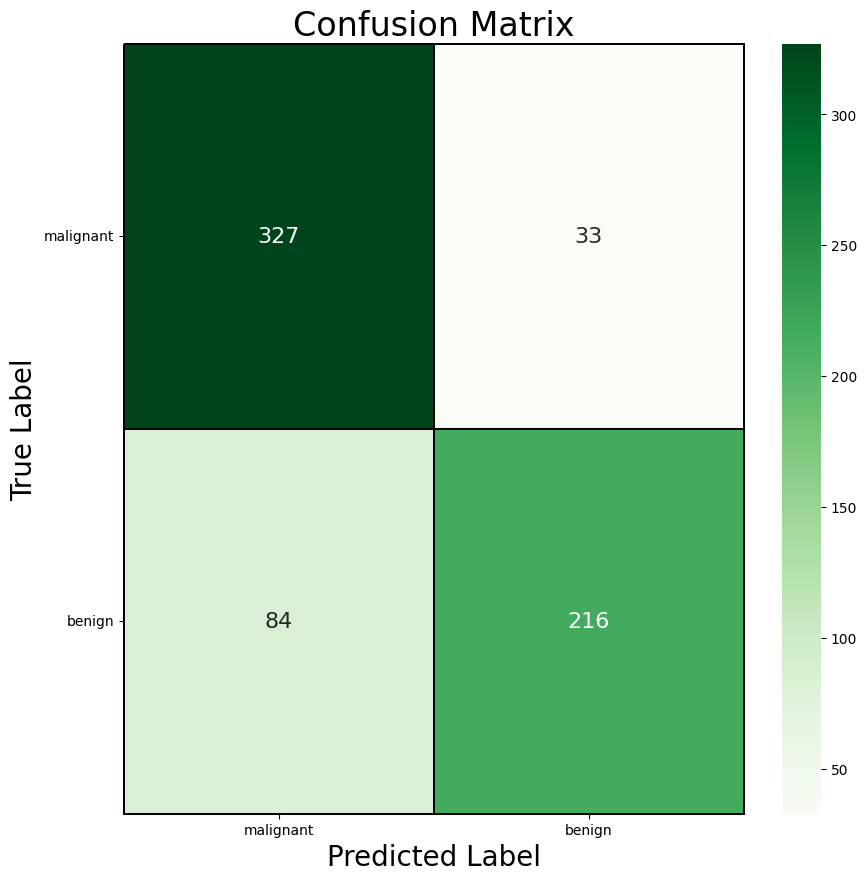

True Negatives: 327
False Positives: 33
False Negatives: 84
True Positives: 216


In [47]:
class_names = ['malignant', 'benign']

plot_confusion_matrix(y_test, test_predictions, classes=class_names, figsize=(10,10), text_size=16)

1/1 [==============================] - 0s 226ms/step
predictions: 
 [0 1 0 1 0 1 0 0 1]
Labels: 
 [0. 1. 0. 1. 0. 1. 0. 0. 1.]


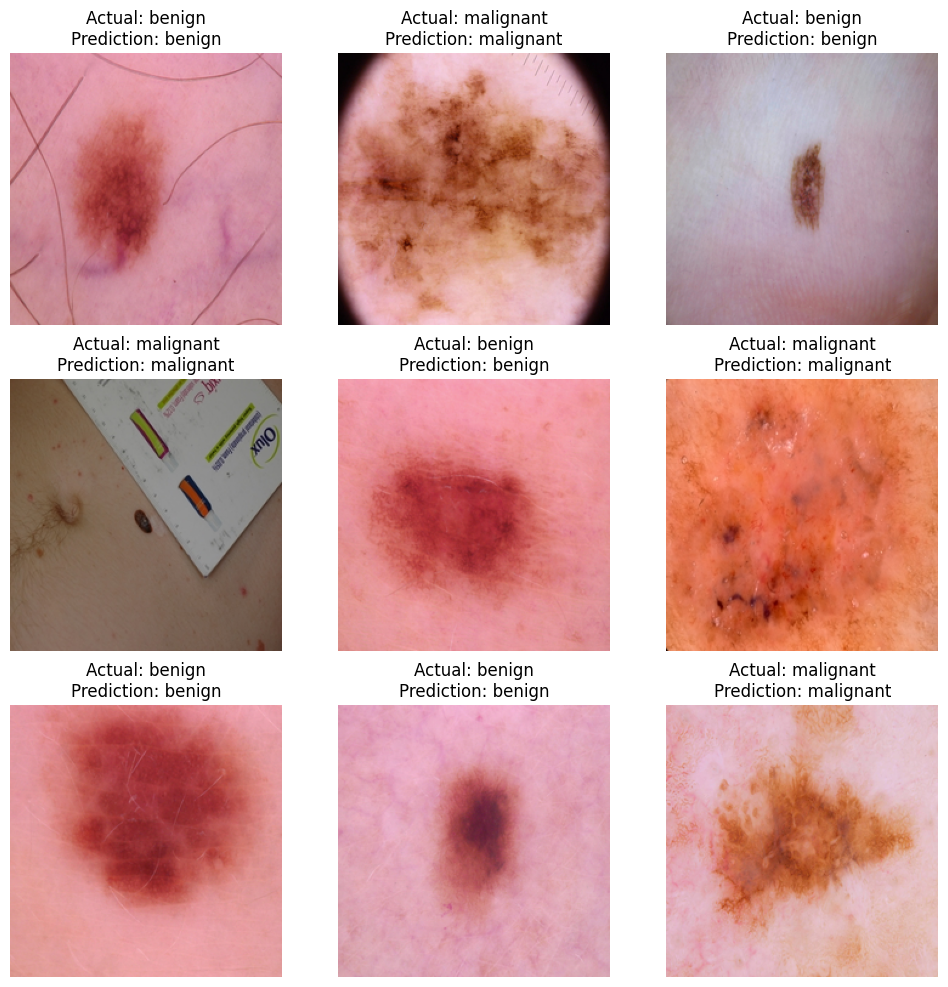

In [49]:
# retrieve 9 random images from test set
random_indices = np.random.randint(0, len(X_test), size=9)
random_images = X_test[random_indices, :]
predictions = model.predict(random_images).flatten()

# Apply a sigmoid since our model returns logits
tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print("predictions: \n", predictions.numpy())
print("Labels: \n", y_test[random_indices])

# convert labels to string
y_test_str = []
for i in range(len(y_test)):
    if y_test[i] == 0:
        y_test_str.append("benign")
    else:
        y_test_str.append("malignant")

# convert predictions to string
predictions_str = []
for i in range(len(predictions)):
    if predictions[i] == 0:
        predictions_str.append("benign")
    else:
        predictions_str.append("malignant")

# Display images with labels and predictions
plt.figure(figsize=(12,12))
for i in range(len(random_images)):
    plt.subplot(3, 3, i+1)
    plt.imshow(random_images[i])
    plt.title("Actual: " + y_test_str[random_indices[i]] + "\n" + "Prediction: " + predictions_str[i])
    plt.axis('off')